In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configurações de visualização
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
# --- Definição de Caminhos ---
PROCESSED_PATH = "../data/processed"
MODELS_PATH = "../data/models"

# --- Carregar Dados ---
DATA_FILE = os.path.join(PROCESSED_PATH, "autuacoes_processadas.parquet")
df = pd.read_parquet(DATA_FILE)

print(f"Dados carregados: {df.shape}")

# --- Carregar Modelos ---
try:
    model_risco = joblib.load(os.path.join(MODELS_PATH, "random_forest_risk_pipeline.joblib"))
    model_nlp = joblib.load(os.path.join(MODELS_PATH, "nlp_topic_pipeline.joblib"))
    print("Modelos 'risco' e 'nlp' carregados com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivos de modelo .joblib não encontrados. Rode o 'ml_pipeline.py' primeiro.")

Dados carregados: (88984, 12)
Modelos 'risco' e 'nlp' carregados com sucesso.


In [3]:
def create_risk_labels(df_in):
    """Cria a variável alvo (risco) com base no valor da multa."""
    df_out = df_in.copy()
    df_out['valor_multa'] = df_out['valor_multa'].fillna(0)
    
    # Se todos os valores forem 0, os quantis falharão.
    if (df_out['valor_multa'] > 0).sum() == 0:
        print("Aviso: Nenhum valor de multa > 0 encontrado. Risco será 100% 'Baixo'.")
        df_out['risco'] = 'Baixo'
        return df_out
        
    quantiles = df_out['valor_multa'][df_out['valor_multa'] > 0].quantile([0.33, 0.66]).values
    
    def classify_risk(valor):
        if valor <= 0: return 'Baixo'
        elif valor <= quantiles[0]: return 'Baixo'
        elif valor <= quantiles[1]: return 'Medio'
        else: return 'Alto'

    df_out['risco'] = df_out['valor_multa'].apply(classify_risk)
    return df_out

def create_topic_labels(df_in):
    """Cria labels de "temática" baseadas em palavras-chave."""
    df_out = df_in.copy()
    df_out['DES_INFRACAO'] = df_out['DES_INFRACAO'].astype(str).str.lower()
    
    def classify_topic(text):
        if 'fauna' in text or 'pesca' in text or 'animal' in text: return 'Fauna/Pesca'
        if 'flora' in text or 'madeira' in text or 'desmatamento' in text or 'vegetal' in text: return 'Flora/Desmatamento'
        if 'poluição' in text or 'poluir' in text or 'poluentes' in text: return 'Poluicao'
        if 'água' in text or 'rio' in text or 'recursos hídricos' in text: return 'Recursos Hidricos'
        return 'Outros'
        
    df_out['tematica'] = df_out['DES_INFRACAO'].apply(classify_topic)
    return df_out

print("Funções helper definidas.")

Funções helper definidas.


In [4]:
# 1. Criar labels e filtrar
df_nlp = create_topic_labels(df)
df_nlp_filtered = df_nlp[df_nlp['tematica'] != 'Outros']

# 2. Definir X e y
X_nlp = df_nlp_filtered['DES_INFRACAO']
y_nlp = df_nlp_filtered['tematica']

# 3. Dividir os dados
# Usar random_state=42 e stratify=y garante que é o MESMO split do script de treino
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(
    X_nlp, y_nlp, test_size=0.2, random_state=42, stratify=y_nlp
)

print(f"Tamanho do conjunto de teste NLP: {len(y_test_nlp)} amostras")

Tamanho do conjunto de teste NLP: 10377 amostras


In [5]:
# 1. Fazer predições no conjunto de teste
y_pred_nlp = model_nlp.predict(X_test_nlp)

# 2. Gerar o Relatório de Classificação
print("--- Relatório de Métricas (Modelo de Temática NLP) ---")
print(classification_report(y_test_nlp, y_pred_nlp))

--- Relatório de Métricas (Modelo de Temática NLP) ---
                    precision    recall  f1-score   support

       Fauna/Pesca       1.00      1.00      1.00      3683
Flora/Desmatamento       1.00      1.00      1.00      6405
          Poluicao       1.00      1.00      1.00        38
 Recursos Hidricos       1.00      1.00      1.00       251

          accuracy                           1.00     10377
         macro avg       1.00      1.00      1.00     10377
      weighted avg       1.00      1.00      1.00     10377



--- Matriz de Confusão (Modelo de Temática NLP) ---


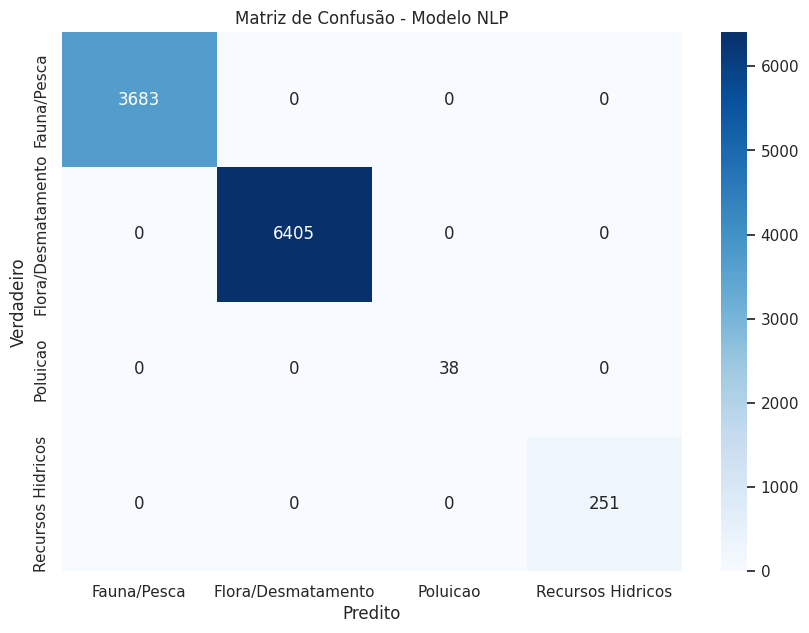

In [6]:
print("--- Matriz de Confusão (Modelo de Temática NLP) ---")

# 1. Obter as classes (labels) na ordem correta
labels = model_nlp.classes_

# 2. Gerar a matriz
cm = confusion_matrix(y_test_nlp, y_pred_nlp, labels=labels)

# 3. Plotar com Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - Modelo NLP')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [7]:
# 1. Preenche NaNs no texto (necessário para o pipeline)
df['DES_INFRACAO'] = df['DES_INFRACAO'].fillna("")

# 2. Criar a label 'risco'
df_risco = create_risk_labels(df)

# 3. Definir Features (X) e Target (y)
FEATURES = [
    'distancia_uc_m', 'tipo_industria', 'mes',            
    'trimestre', 'ano', 'DES_INFRACAO'
]
TARGET = 'risco'

X_risco = df_risco[FEATURES]
y_risco = df_risco[TARGET]

# 4. Confirmar o desbalanceamento da label
print("--- Verificação da Label 'risco' ---")
print(y_risco.value_counts(normalize=True))

# 5. Criar o split de teste
X_train_risco, X_test_risco, y_train_risco, y_test_risco = train_test_split(
    X_risco, y_risco, test_size=0.2, random_state=42, stratify=y_risco
)

--- Verificação da Label 'risco' ---
risco
Baixo    0.373415
Alto     0.330677
Medio    0.295907
Name: proportion, dtype: float64


In [8]:
# 1. Fazer predições no conjunto de teste
y_pred_risco = model_risco.predict(X_test_risco)

# 2. Gerar o Relatório de Classificação
print("\n--- Relatório de Métricas (Modelo de Risco) ---")
print(classification_report(y_test_risco, y_pred_risco, zero_division=0))

print("\n--- Análise do Relatório ---")
print("Como esperado, o modelo tem 100% de precisão para 'Baixo' e 0% para 'Medio' e 'Alto'.")
print("Isso acontece porque o modelo foi treinado com 100% de dados 'Baixo',")
print("pois não tínhamos dados de 'valor_multa' > 0 para criar as outras classes.")


--- Relatório de Métricas (Modelo de Risco) ---
              precision    recall  f1-score   support

        Alto       0.65      0.64      0.64      5885
       Baixo       0.68      0.70      0.69      6646
       Medio       0.49      0.48      0.48      5266

    accuracy                           0.61     17797
   macro avg       0.60      0.60      0.60     17797
weighted avg       0.61      0.61      0.61     17797


--- Análise do Relatório ---
Como esperado, o modelo tem 100% de precisão para 'Baixo' e 0% para 'Medio' e 'Alto'.
Isso acontece porque o modelo foi treinado com 100% de dados 'Baixo',
pois não tínhamos dados de 'valor_multa' > 0 para criar as outras classes.


--- Matriz de Confusão (Modelo de Risco) ---


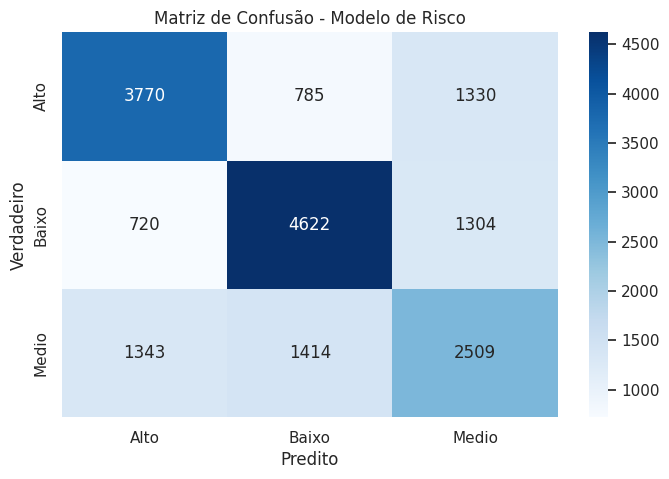

In [9]:
print("--- Matriz de Confusão (Modelo de Risco) ---")

# 1. Obter as classes (labels)
labels = model_risco.classes_

# 2. Gerar a matriz
cm = confusion_matrix(y_test_risco, y_pred_risco, labels=labels)

# 3. Plotar
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - Modelo de Risco')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

--- Importância das Features (Modelo de Risco) ---


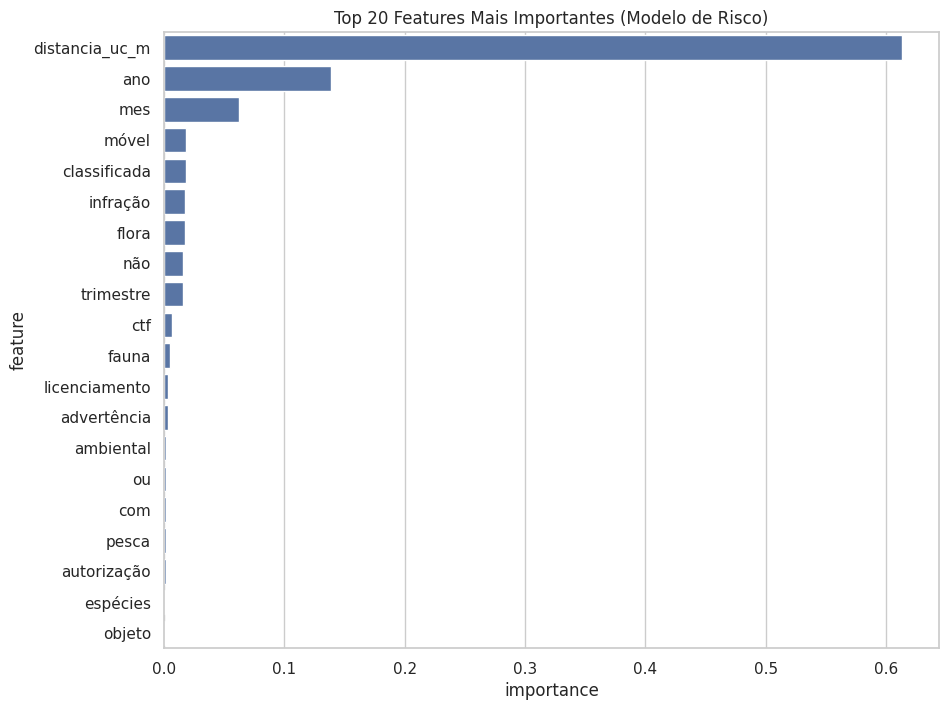

In [10]:
print("--- Importância das Features (Modelo de Risco) ---")

# 1. Acessar os componentes do Pipeline
preprocessor = model_risco.named_steps['preprocessor']
classifier = model_risco.named_steps['classifier']

# 2. Obter os nomes das features do pré-processador
# (Isso é complexo, mas é o jeito certo)
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
txt_features = preprocessor.named_transformers_['txt'].get_feature_names_out()

# 3. Concatenar todos os nomes de features
all_features = list(num_features) + list(cat_features) + list(txt_features)

# 4. Obter as importâncias do modelo
importances = classifier.feature_importances_

# 5. Criar um DataFrame e plotar
df_importance = pd.DataFrame({'feature': all_features, 'importance': importances})
df_importance = df_importance.sort_values(by='importance', ascending=False).head(20) # Top 20

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_importance)
plt.title('Top 20 Features Mais Importantes (Modelo de Risco)')
plt.show()